100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Epoch: 1 Loss: 0.062071189284324646
Epoch: 2 Loss: 0.06934712082147598
Epoch: 3 Loss: 0.06717751920223236
Epoch: 4 Loss: 0.06014202535152435
Epoch: 5 Loss: 0.046961210668087006
Epoch: 6 Loss: 0.04492458701133728
Epoch: 7 Loss: 0.05885830149054527
Epoch: 8 Loss: 0.04780780151486397
Epoch: 9 Loss: 0.05747998133301735
Epoch: 10 Loss: 0.055160120129585266


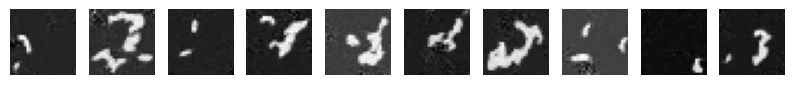

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)

T = 300
beta_start = 0.0001
beta_end = 0.02

betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1 - betas
alpha_hat = torch.cumprod(alphas, dim=0)

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise

epochs = 10

for epoch in range(epochs):

    for images, _ in loader:

        images = images.to(device)

        t = torch.randint(0, T, (images.size(0),)).to(device)

        noisy_images, noise = forward_diffusion(images, t)

        predicted_noise = model(noisy_images)

        loss = loss_fn(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch:", epoch+1, "Loss:", loss.item())

model.eval()

with torch.no_grad():

    x = torch.randn(10, 1, 28, 28).to(device)

    for t in reversed(range(T)):

        t_tensor = torch.tensor([t]).to(device)

        beta = betas[t]
        alpha = alphas[t]
        alpha_h = alpha_hat[t]

        noise_pred = model(x)

        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_h)) * noise_pred)

        if t > 0:
            noise = torch.randn_like(x)
            x = x + torch.sqrt(beta) * noise

samples = x.cpu()

plt.figure(figsize=(10,2))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(samples[i][0], cmap="gray")
    plt.axis("off")

plt.show()
